In [1]:
import pandas as pd
import numpy as np
import pickle


from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import pickle
import sys
import os
from sklearn import metrics
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
plt.style.use('ggplot')

In [2]:
def plotROC(n_classes, y_test, y_score, output):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.savefig(output + str(i) + ".png")

In [3]:
def plotConfusionMatrix(matrix, output):
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = ['Deceased', 'Hospitalized', 'Nonhospitalized', 
                'Recovered']
    tick_marks = np.arange(len(class_names)) + 0.5
    tick_marks2 = tick_marks
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for XGBoost')
    plt.savefig(output)

In [4]:
# RANDOOM FOREST PORTION 
df = pd.read_csv("../data/cases_train_processed.csv")
df = df.dropna()

In [5]:
#Make outcome numeric

df['outcome'] = df.outcome.astype('category')
outcomes = dict(enumerate(df.outcome.cat.categories))
print (outcomes)

df['outcome'] = df.outcome.cat.codes

{0: 'deceased', 1: 'hospitalized', 2: 'nonhospitalized', 3: 'recovered'}


In [6]:
#Divide into y and X
y = df.outcome
X = df.drop(['outcome', 'province', 'country', 'latitude', 'longitude', 'additional_information', 'source'], axis = 'columns')
X = pd.get_dummies(X)

In [7]:
#Split the train dataset further into train dataset and validation dataset
msk = np.random.rand(len(df)) < 0.8

train_X = X[msk]
train_y = y[msk]
validate_X = X[~msk]
validate_y = y[~msk]

print(len(train_X))
print(len(train_y))

print(len(validate_X))
print(len(validate_y))

validate_X


264576
264576
66341
66341


,age,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,sex_female,sex_male,sex_unknown,...,date_confirmation_29.03.2020,date_confirmation_29.04.2020,date_confirmation_29.05.2020,date_confirmation_30.01.2020,date_confirmation_30.03.2020,date_confirmation_30.04.2020,date_confirmation_30.05.2020,date_confirmation_31.01.2020,date_confirmation_31.03.2020,date_confirmation_31.05.2020
0,-1,238828.0,4907.0,201671.0,32250.0,1276.409575,2.054617,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-1,120336.0,3286.0,100974.0,16076.0,188.400627,2.730687,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,-1,1167496.0,31791.0,834432.0,301273.0,948.072083,2.723007,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,35,64465.0,2648.0,56398.0,5419.0,492.975265,4.107655,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13,-1,530908.0,8685.0,475717.0,46506.0,682.039258,1.635877,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367597,-1,530908.0,8685.0,475717.0,46506.0,682.039258,1.635877,0,0,1,...,0,0,0,0,0,0,0,0,0,0
367599,-1,100458.0,1901.0,76952.0,21605.0,117.688868,1.892333,0,0,1,...,0,1,0,0,0,0,0,0,0,0
367600,-1,238828.0,4907.0,201671.0,32250.0,1276.409575,2.054617,0,0,1,...,0,0,0,0,0,0,0,0,0,0
367603,-1,120336.0,3286.0,100974.0,16076.0,188.400627,2.730687,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Build RandomForests Model
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(train_X, train_y)

RandomForestClassifier(random_state=0)

In [23]:
filename = '../models/rf_classifier.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [10]:
rf.score(train_X, train_y)

0.825229801644896

In [11]:
rf.score(validate_X, validate_y)

0.8195384453053165

In [12]:
train_predicted = rf.predict(train_X)
validate_predicted = rf.predict(validate_X)

[[  576  2189    67   759]
 [    4 85031     0 11846]
 [   20     1 93608   311]
 [   29 30803   211 39121]]


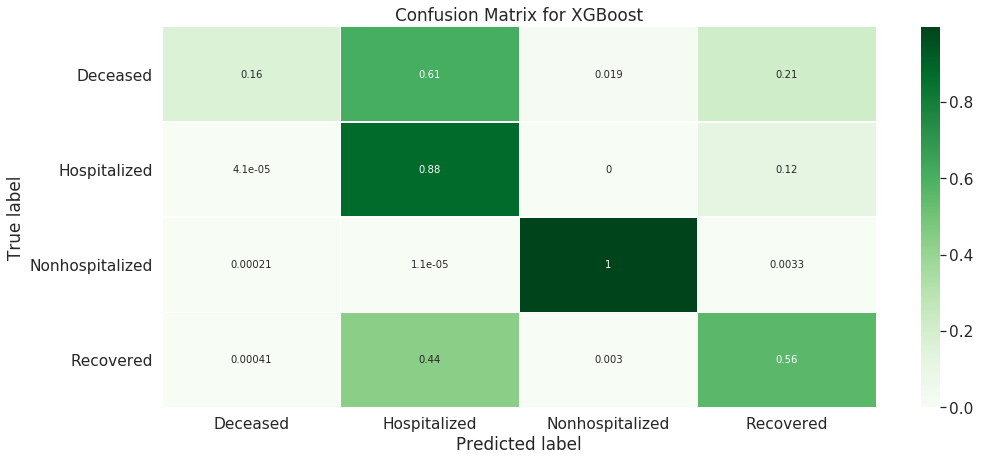

In [13]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(train_y, train_predicted)
print(matrix)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plotConfusionMatrix(matrix, "../plots/rf_train_cm.png")

[[   55   536    43   208]
 [   15 21424     2  3000]
 [   35     4 23349   201]
 [   46  7700   182  9541]]


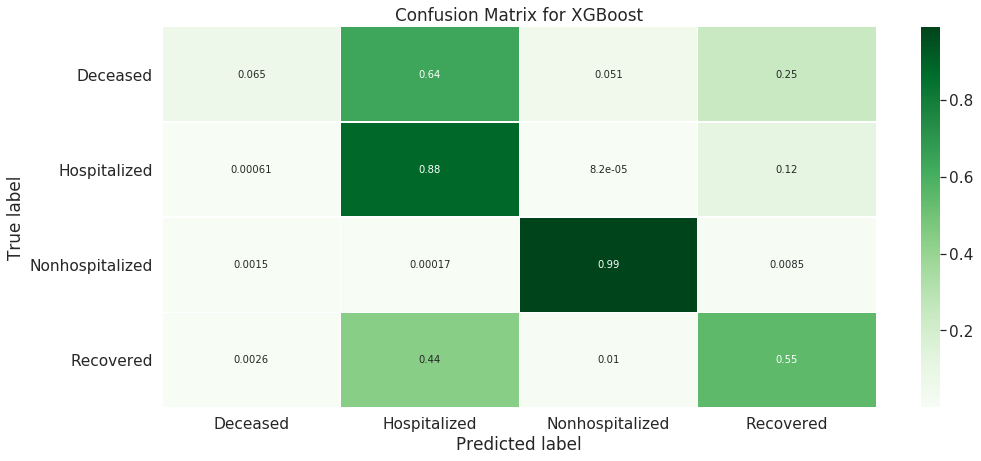

In [14]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(validate_y, validate_predicted)
print(matrix)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plotConfusionMatrix(matrix, "../plots/rf_validate_cm.png")

In [15]:

print(classification_report(train_y, train_predicted))
print(classification_report(validate_y, validate_predicted))

              precision    recall  f1-score   support

           0       0.92      0.16      0.27      3591
           1       0.72      0.88      0.79     96881
           2       1.00      1.00      1.00     93940
           3       0.75      0.56      0.64     70164

    accuracy                           0.83    264576
   macro avg       0.85      0.65      0.68    264576
weighted avg       0.83      0.83      0.82    264576

              precision    recall  f1-score   support

           0       0.36      0.07      0.11       842
           1       0.72      0.88      0.79     24441
           2       0.99      0.99      0.99     23589
           3       0.74      0.55      0.63     17469

    accuracy                           0.82     66341
   macro avg       0.70      0.62      0.63     66341
weighted avg       0.82      0.82      0.81     66341



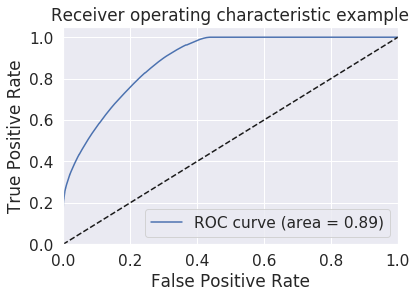

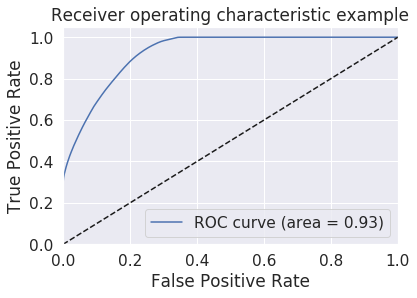

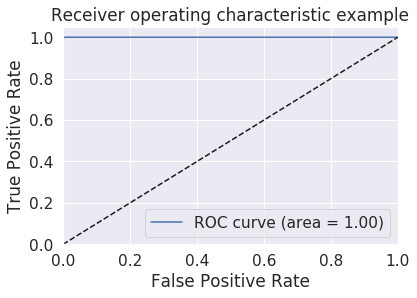

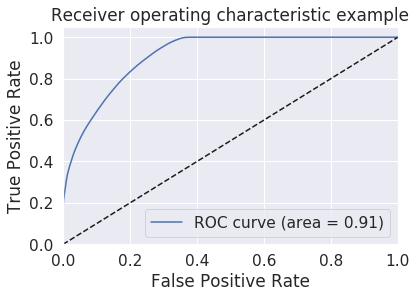

In [16]:
#ROC for train

y_score = rf.predict_proba(train_X)
lb = preprocessing.LabelBinarizer()
lb.fit(train_y.values.flatten())
NEWy_test = lb.transform(train_y.values.flatten())

plotROC(4, NEWy_test, y_score, "../plots/rf_train_roc-class")

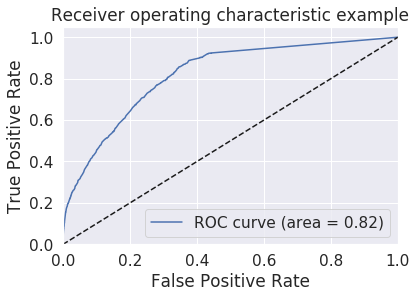

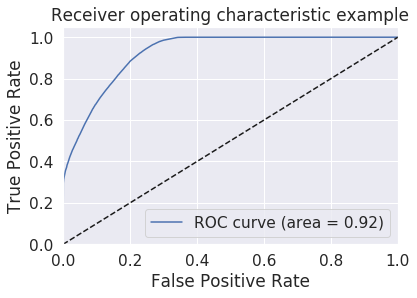

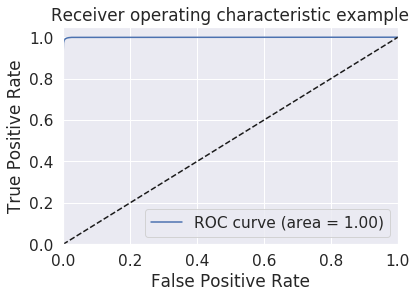

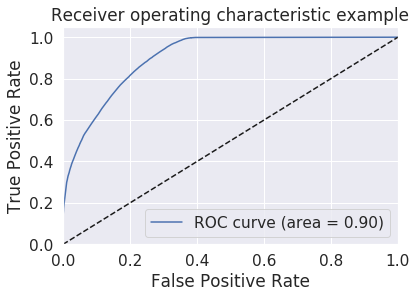

In [17]:
#ROC for train

y_score = rf.predict_proba(validate_X)
lb = preprocessing.LabelBinarizer()
lb.fit(validate_y.values.flatten())
NEWy_test = lb.transform(validate_y.values.flatten())

plotROC(4, NEWy_test, y_score, "../plots/rf_validate_roc-class")

In [18]:
#XGBOOST PORTION
df = pd.read_csv("../results/cases_train_processed.csv")

cases_trainTrain = df
cases_trainValid = df

dataX = cases_trainTrain
dataY =  cases_trainTrain[['outcome']].copy()
del dataX["outcome"]

lbl = preprocessing.LabelEncoder()
#sex -> unkown: 2 , male: 1, female: 2

dataX['sex'] = lbl.fit_transform(dataX['sex'].astype(str))
dataX['province'] = lbl.fit_transform(dataX['province'].astype(str))
dataX['country'] = lbl.fit_transform(dataX['country'].astype(str))
dataX['date_confirmation'] = lbl.fit_transform(dataX['date_confirmation'].astype(str))
dataX['additional_information'] = lbl.fit_transform(dataX['additional_information'].astype(str))
dataX['source'] = lbl.fit_transform(dataX['source'].astype(str))
dataY['outcome'] = lbl.fit_transform(dataY['outcome'].astype(str))

In [19]:
data_dmatrix = xgb.DMatrix(data=dataX,label=dataY)

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=123)

defaultParams = {"max_depth":6, "learning_rate":0.3, "n_estimators":100,  "objective":'binary:logistic',"booster":'gbtree',"n_jobs":1,"nthread":None,
"gamma":0,"min_child_weight":1,"max_delta_step":0,"subsample":1,"colsample_bytree":1,"colsample_bylevel":1,"reg_alpha":0,"reg_lambda":1,"base_score":0.5,
"random_state":0,"seed":None,"missing":None}

xg_class  = xgb.XGBClassifier(use_label_encoder=False)
xg_class.set_params(**defaultParams)

metLearn=CalibratedClassifierCV(xg_class, method='isotonic', cv=5)
metLearn.fit(X_train, y_train)

/home/rwasser/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[16:36:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore t

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=None,
                                                    colsample_bytree=1, gamma=0,
                                                    gpu_id=None,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=0.3,
                                                    max_delta_step=0,
                                                    max_depth=6,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    monotone_const

In [22]:
#SAVE MODEL
filename = '../models/xgb_classifier.pkl'
pickle.dump(metLearn, open(filename, 'wb'))

[2 3 1 ... 2 1 2]
Accuracy for train: 88.55%
Accuracy for validation: 88.13%


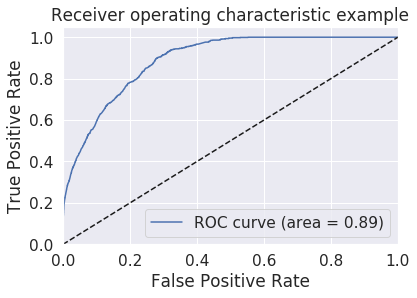

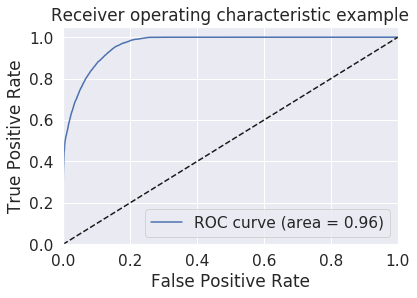

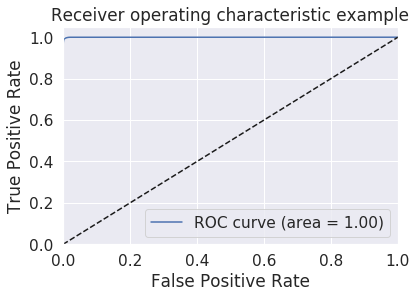

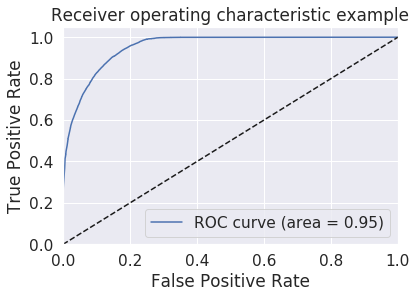

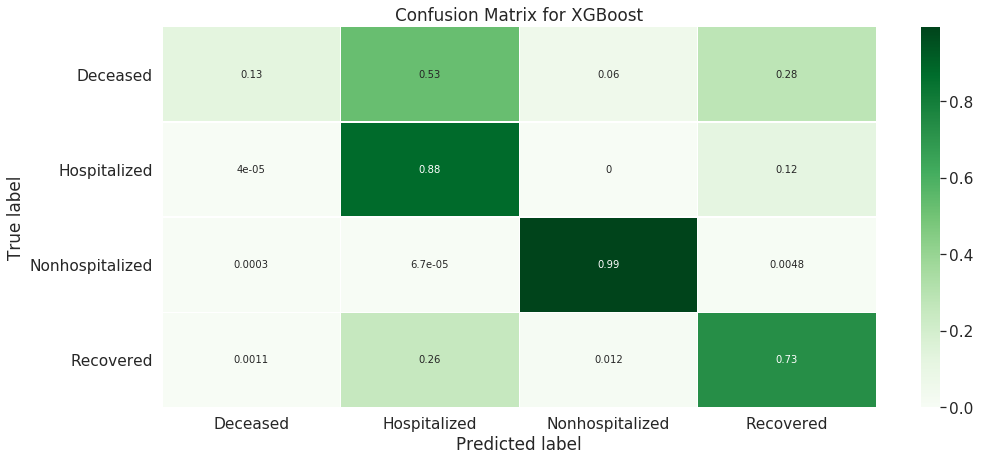

In [21]:
trainPredictions = metLearn.predict(X_train)
testPredictions = metLearn.predict(X_test)
c = y_train.values.flatten()
b=y_test.values.flatten()
temp = b
y_score = metLearn.predict_proba(X_test)


lb = preprocessing.LabelBinarizer()
lb.fit(y_test.values.flatten())
hi = lb.transform(y_test.values.flatten())

plotROC(4,hi,y_score, "../plots/xgb_validate_roc-class")

test = multilabel_confusion_matrix(c, trainPredictions)
#print(test)

matrix = confusion_matrix(b,testPredictions)
plotConfusionMatrix(matrix, "../plots/xgb_validate_cm.png")


accuracyTrain = accuracy_score(y_train, trainPredictions)
accuracyTest = accuracy_score(y_test, testPredictions)
print(testPredictions)
print("Accuracy for train: %.2f%%" % (accuracyTrain * 100.0))
print("Accuracy for validation: %.2f%%" % (accuracyTest* 100.0))